# Finite State Machine Analysis

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import (pprint as pp, pformat as pf)
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import dmyplant2
dmyplant2.cred()
mp = dmyplant2.MyPlant(3600)

### Filter Engines from installed fleet 

In [39]:
def sfun(x):
    #return (("Forsa Hartmoor" in str(x['IB Site Name'])) and 
    return (("Landshut" in str(x['IB Site Name'])) and 
        (x['OperationalCondition'] != 'Decommissioned') and
        (x['Engine ID'] == 'M4'))

res = mp.search_installed_fleet(sfun)
res = res.sort_values(by = "Engine ID",ascending=True)
res.T

,0
index,20616
Count_OpHour,17886.0
OperationalCondition,Running
startup_counter,1042.0
shutdown_counter,1050.0
id,117617
Engine Version,H01
Engine Type,624
Engine Series,6
Country,DE


In [40]:
dval = mp.def_from_installed_fleet(res)
dval.T

Loading Myplant Data: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2283.24 engines/s]


,0
n,0
Validation Engine,BMW Landshut 4.10 M4
serialNumber,1320072
val start,2019-01-09 00:00:00
oph@start,-1
starts@start,-1
Asset ID,117617.0


In [41]:
# Ammerlaan Flowers 2, J420 Frage von David Sepulveda Lopez
#e=dmyplant2.Engine.from_sn(mp,5640011)
#dval.iloc[0]['serialNumber']
e=dmyplant2.Engine.from_sn(mp,dval.iloc[0]['serialNumber'])

In [42]:
pd.DataFrame.from_dict(e.dash, orient='index').T

,Name,Engine ID,Design Number,Engine Type,Engine Version,P,P_nom,BMEP,serialNumber,id,Count_OpHour,val start,oph@start,oph parts,LOC
0,BMW Landshut 4.10 M4,M4,U781,624,H01,24,4587.2,24.5,1320072,117617,17886.0,2019-01-09,1384,16502,0.0865


In [43]:
from dfsm import msgFSM
fsm_data = []
#fsm = msgFSM(e, skip_day=7)
#fsm = msgFSM(e, p_from='2022-01-11')
fsm = msgFSM(e)
fsm.run() # run Finite State Machine
fsm_data.append({'engine':e, 'fsm':fsm})

Calculating '9047 target load reached' Message.
load ramp assumed to 0.72 %/sec based on rP_Ramp_Set Parameter


FSM: 100%|████████████████████| 172325/172325 [00:13<00:00, 12399.36 messages/s]


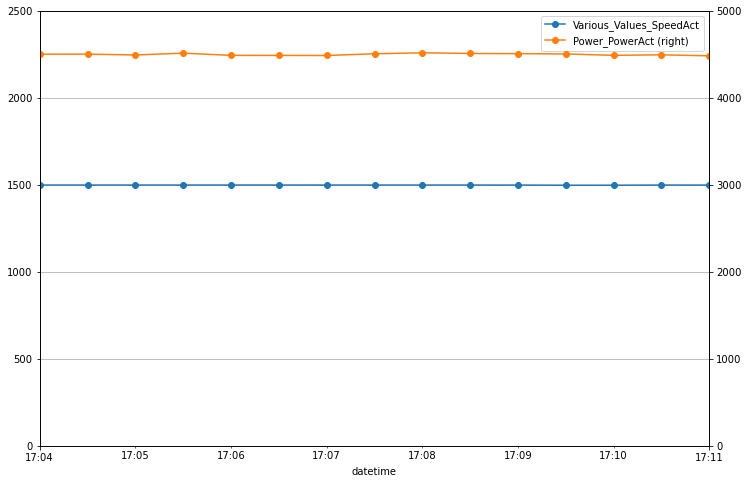

In [44]:
fsm.plot_ts(1637687335601, marker='o', ylim=(0,2500), figsize=(12,8));
plt.show()

In [45]:
res = fsm_data[0]
res['result'] = pd.DataFrame(fsm_data[0]['fsm']._starts)
print(f"""
*****************************************
** {str(res['engine'])} **
*****************************************""")
print(f"{'Meldung':9} '{'9047 target load reached'}' {'gefunden.' if any(res['fsm']._messages['name'] == '9047') else 'wird berechnet.'}")
print(f"{'Zeitraum':9}: {res['fsm'].first_message:%d.%m.%Y} bis {res['fsm'].last_message:%d.%m.%Y}")
print(f"{'Dauer':9}: {res['fsm'].period.days:5} Tage")
print(f"{'GESAMT':9}: {res['result'].shape[0]:5} Starts, {res['result'][res['result'].success].shape[0]:5} erfolgreich => {(res['result'][res['result'].success].shape[0] / res['result'].shape[0]) * 100.0:3.1f} % der Starts erfolgreich.")
for mode in ['???','OFF','MANUAL', 'AUTO']:
    lstarts = res['result'][res['result']['mode'] == mode].shape[0]
    successful_starts = res['result'][((res['result'].success) & (res['result']['mode'] == mode))].shape[0]
    print(f"{mode:9}: {lstarts:5} Starts, {successful_starts:5} erfolgreich => {(successful_starts / lstarts) * 100.0 if lstarts != 0 else 0.0:3.1f} % der Starts erfolgreich.")
#res['filtered_result'][['start-preparation','starter','hochlauf','idle','synchronize','cumstarttime','load-ramp','target-operation']].hist(figsize = (20,12), bins=50, layout=(3,3));


*****************************************
** 1320072 BMW Landshut 4.10 M4 **
*****************************************
Meldung   '9047 target load reached' wird berechnet.
Zeitraum : 17.01.2018 bis 22.02.2022
Dauer    :  1497 Tage
GESAMT   :  1620 Starts,  1102 erfolgreich => 68.0 % der Starts erfolgreich.
???      :     0 Starts,     0 erfolgreich => 0.0 % der Starts erfolgreich.
OFF      :    34 Starts,     7 erfolgreich => 20.6 % der Starts erfolgreich.
MANUAL   :   173 Starts,    38 erfolgreich => 22.0 % der Starts erfolgreich.
AUTO     :  1413 Starts,  1057 erfolgreich => 74.8 % der Starts erfolgreich.


In [46]:
rdf = res['result']
# filter als pleased :-)
#rda = rdf
#rda = rdf[((rdf['mode'] == 'AUTO') & (rdf['success'] == True))]
#rda = rdf[((rdf['mode'] == 'AUTO') & (rdf['success'] == True) & (rdf['synchronize'] < 300.0) & (rdf['start-preparation'] < 300.0))]
#rda = rdf[((rdf['success'] == True) & (rdf['start-preparation'] < 1000.0))]
rda = rdf[((rdf['success'] == True))]
rda[fsm.filter_content].round(2)

,success,mode,start-preparation,starter,hochlauf,idle,synchronize,load-ramp,cumstarttime,target-operation
43,True,MANUAL,221.58,4.02,13.60,26.80,34.67,138.89,439.55,1 days 00:01:58
44,True,MANUAL,173.28,4.64,12.80,6.96,104.68,138.89,441.26,0 days 00:48:52
45,True,MANUAL,135.95,4.61,13.04,7.05,77.83,138.89,377.37,0 days 00:03:52
46,True,MANUAL,227.36,4.34,13.60,7.96,7.08,138.89,399.23,0 days 00:48:08
62,True,MANUAL,335.59,4.52,16.50,20.53,9.87,138.89,525.91,0 days 00:32:53
...,...,...,...,...,...,...,...,...,...,...
1615,True,AUTO,261.74,4.54,14.13,6.56,17.08,138.89,442.95,0 days 00:15:22
1616,True,AUTO,261.62,6.24,13.00,6.35,20.20,138.89,446.30,0 days 02:36:50
1617,True,AUTO,261.84,4.44,14.61,6.37,27.53,138.89,453.68,0 days 00:17:39
1618,True,AUTO,261.58,4.95,14.02,6.47,19.39,138.89,445.29,0 days 02:18:03


In [47]:
rda.describe().round(2).T;

In [48]:
longer_than_300s = rda[fsm.filter_period + fsm.filter_content][rdf['cumstarttime'] > 300.0]
longer_than_300s[fsm.filter_content].round(2);

In [49]:
#for i, r in longer_than_300s.iterrows():
#    fsm.plot_cycle(r, max_length=20*60, ylim=(0,5000), title=f"{fsm._e}{r['starttime'].round('S')}: cumstarttime: {r['cumstarttime']}s");

In [50]:
longer_than_300s.describe().round(2).T;

In [51]:
load_ramp_less_than_100s = rda[fsm.filter_period + fsm.filter_content][rdf['load-ramp'] < 100.0]
lfsm = load_ramp_less_than_100s[fsm.filter_content].reset_index(drop='index').round(2)
lfsm

,success,mode,start-preparation,starter,hochlauf,idle,synchronize,load-ramp,cumstarttime,target-operation


In [52]:
rda.reset_index(drop='index').iloc[10];

Load Data: 50000 datarows [00:01, 29773.78 datarows/s]                          


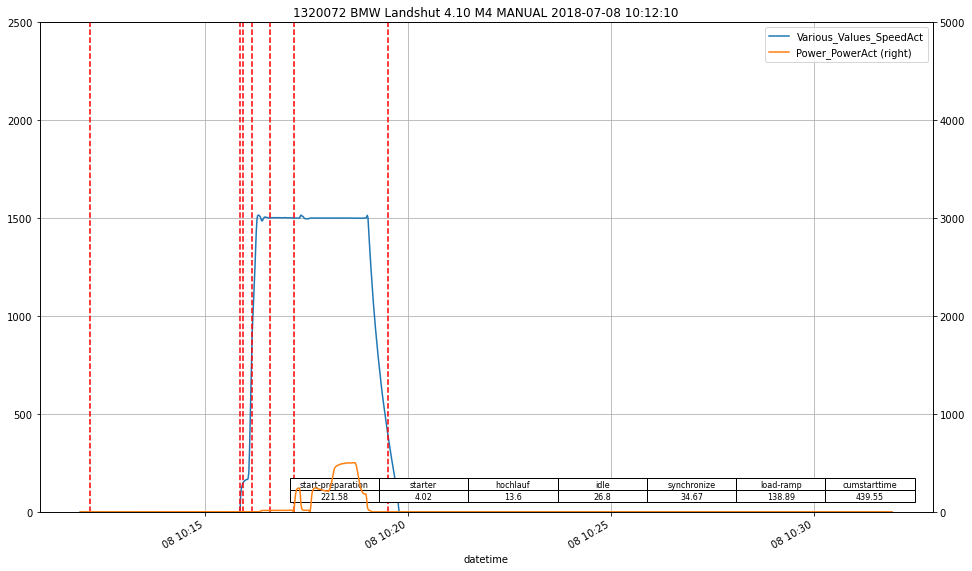

Load Data: 50000 datarows [00:00, 254481.56 datarows/s]                         


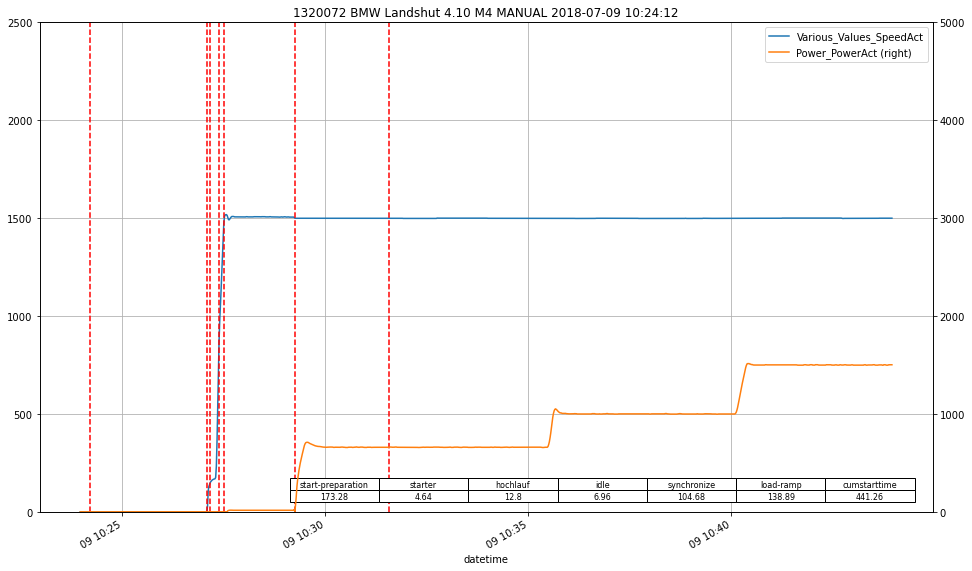

Load Data: 50000 datarows [00:00, 265379.98 datarows/s]                         


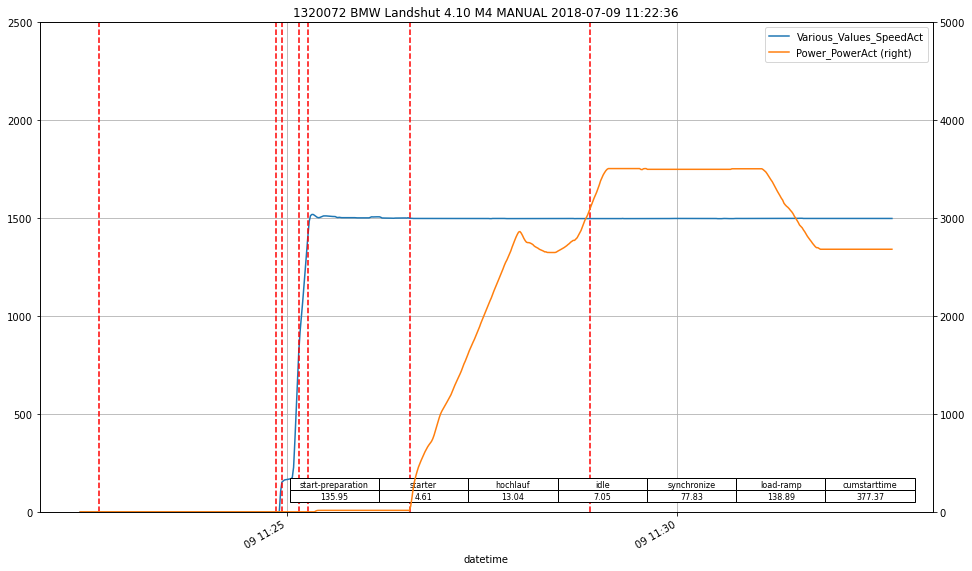

Load Data: 50000 datarows [00:00, 277761.49 datarows/s]                         


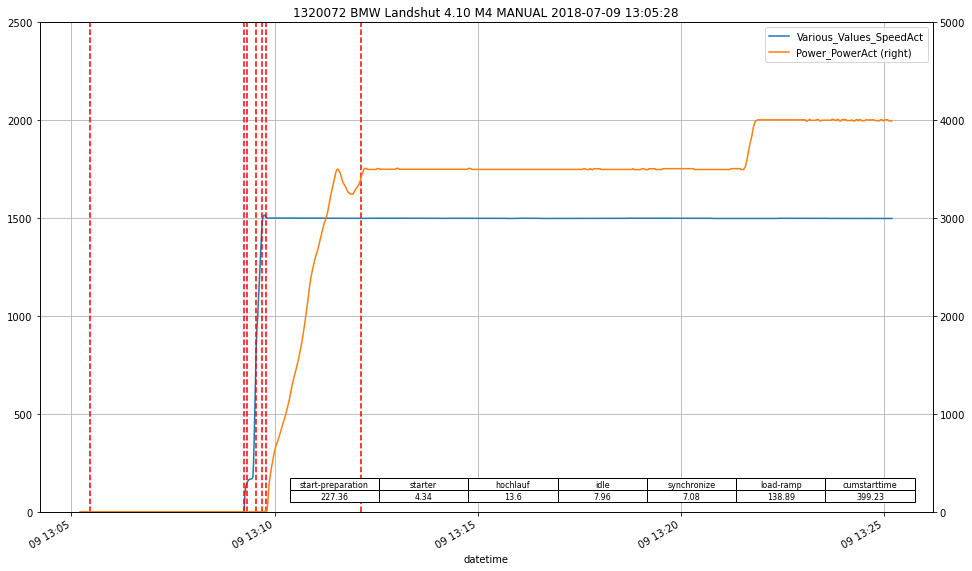

Load Data: 50000 datarows [00:00, 162371.43 datarows/s]                         


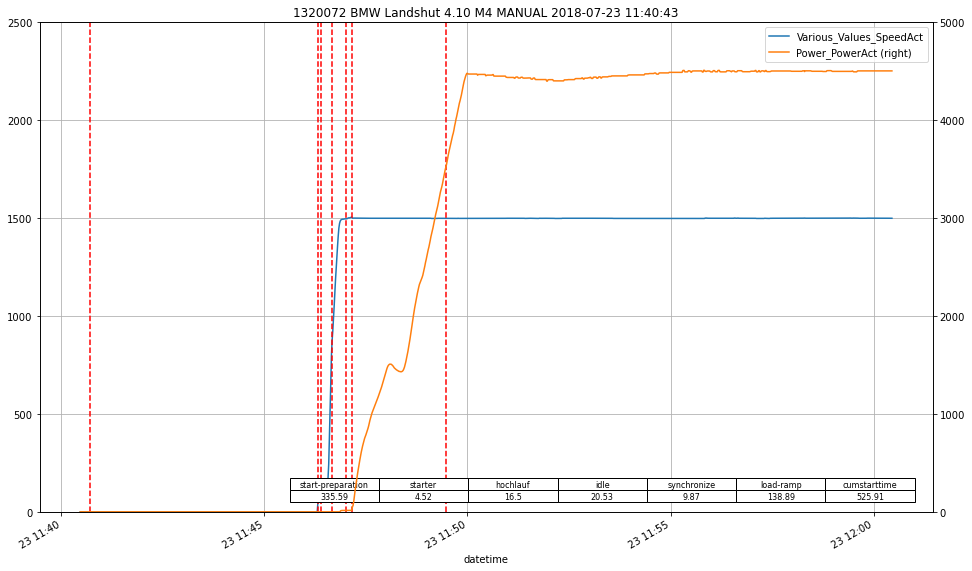

In [63]:
#r = load_ramp_less_than_100s.reset_index(drop='index').iloc[0]
for i in np.arange(0,5):
    r = rda.reset_index(drop='index').iloc[i]
    r_summary = pd.DataFrame(r[fsm.filter_times], dtype=np.float64).round(2).T
    r_summary;
    fsm.plot_cycle(r, max_length=20*60, ylim=(0,2500), cycletime=1, marker=None, figsize=(16,10), title=f"{fsm._e} {r['mode']} {r['starttime'].round('S')}");
    plt.show()

In [54]:
for i, r in load_ramp_less_than_100s.reset_index(drop='index').iterrows():
    fsm.plot_cycle(r, max_length=8*60, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {r['starttime'].round('S')}")
    plt.show()


In [55]:
load_ramp_less_than_100s.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
start-preparation,0.0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
starter,0.0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
hochlauf,0.0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
idle,0.0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
synchronize,0.0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
load-ramp,0.0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
cumstarttime,0.0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
target-operation,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT


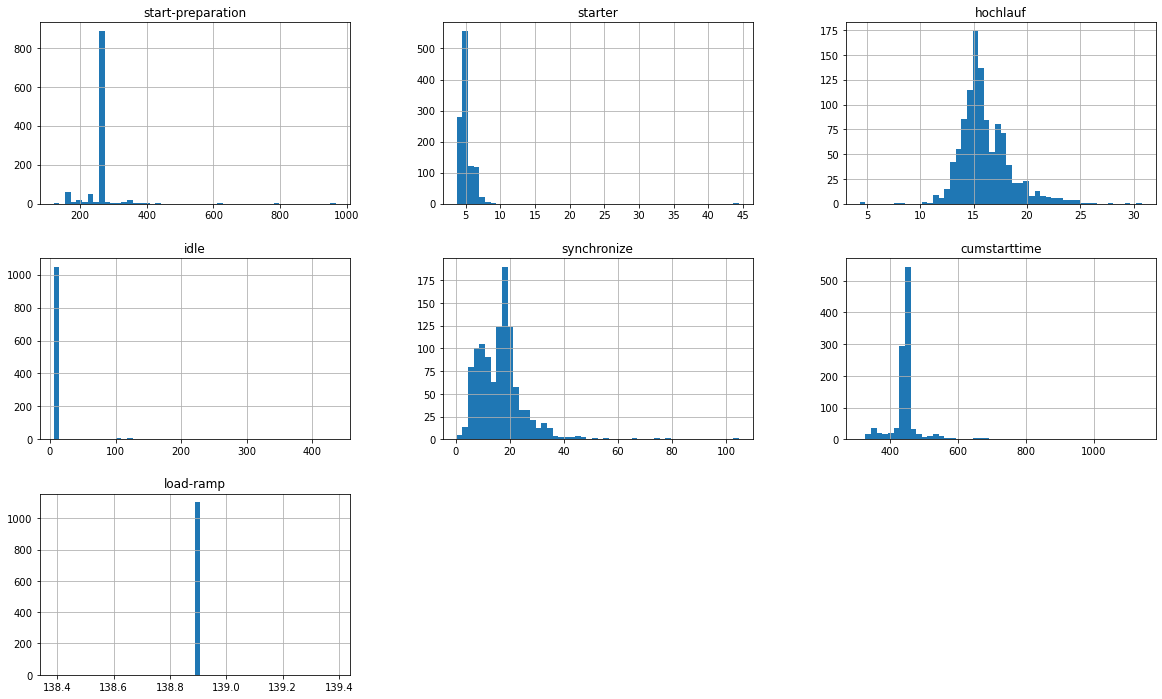

In [56]:
rda[['start-preparation','starter','hochlauf','idle','synchronize','cumstarttime','load-ramp','target-operation']].hist(figsize = (20,12), bins=50, layout=(3,3));
#rda.hist(figsize = (20,12), bins=100, layout=(4,2));

In [57]:
#rda.plot.box(subplots=True, grid = True, figsize=(24,10), layout=(1,7));
#rda.plot.box(subplots=True, grid = True, figsize=(24,10), layout=(1,7), sym='');


Startversuch: 0, Success: False
0 MANUAL          start-preparation    1530184251788 28.06.2018 11:10:51 3324 Failure pre chamber gas compressor

Startversuch: 1, Success: False
1 MANUAL          start-preparation    1530184403039 28.06.2018 11:13:23 3324 Failure pre chamber gas compressor

Startversuch: 2, Success: False
2 MANUAL          start-preparation    1530184612169 28.06.2018 11:16:52 1028 Gas pressure low in gas train 1

Startversuch: 3, Success: False
3 MANUAL          start-preparation    1530184943267 28.06.2018 11:22:23 1138 Engine room ventilation failure

Startversuch: 4, Success: False
4 MANUAL          start-preparation    1530185022149 28.06.2018 11:23:42 1138 Engine room ventilation failure

Startversuch: 5, Success: False
5 MANUAL          start-preparation    1530185110141 28.06.2018 11:25:10 1138 Engine room ventilation failure

Startversuch: 6, Success: False
6 MANUAL          start-preparation    1530185176055 28.06.2018 11:26:16 1138 Engine room ventilation f

Load Data: 50000 datarows [00:00, 61981.99 datarows/s]                          


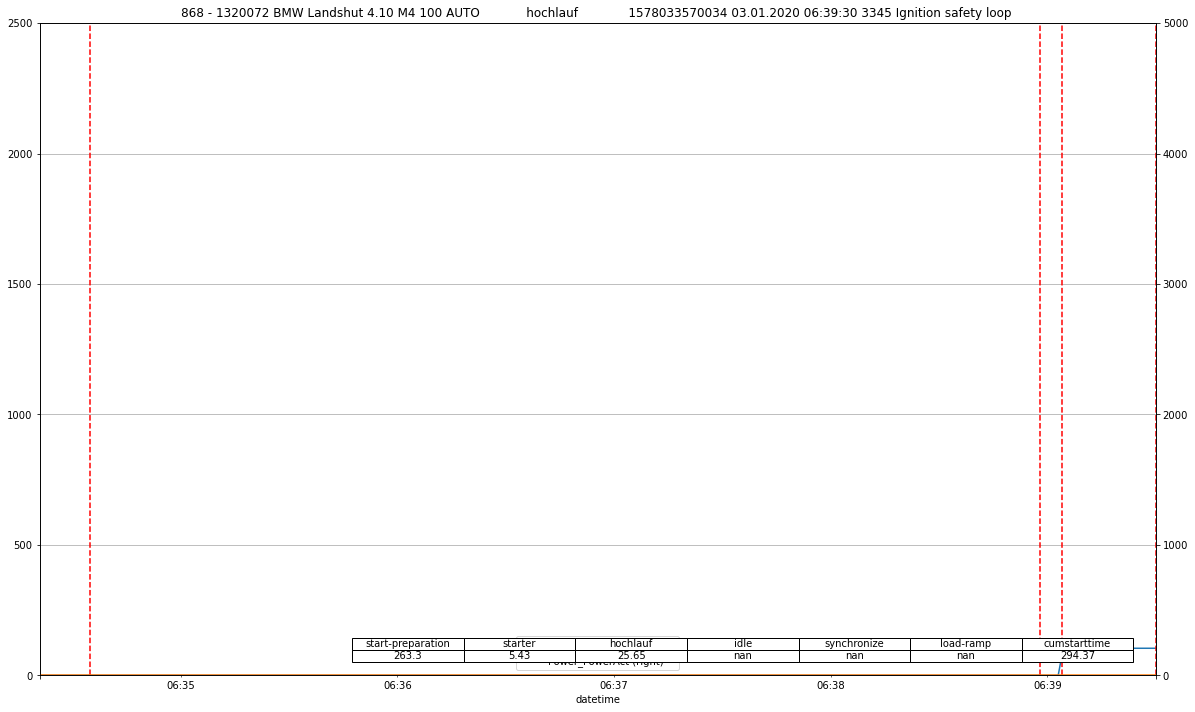


Startversuch: 877, Success: False
101 MANUAL          start-preparation    1581062179519 07.02.2020 07:56:19 1028 Gas pressure low in gas train 1


Load Data: 50000 datarows [00:00, 242597.05 datarows/s]                         


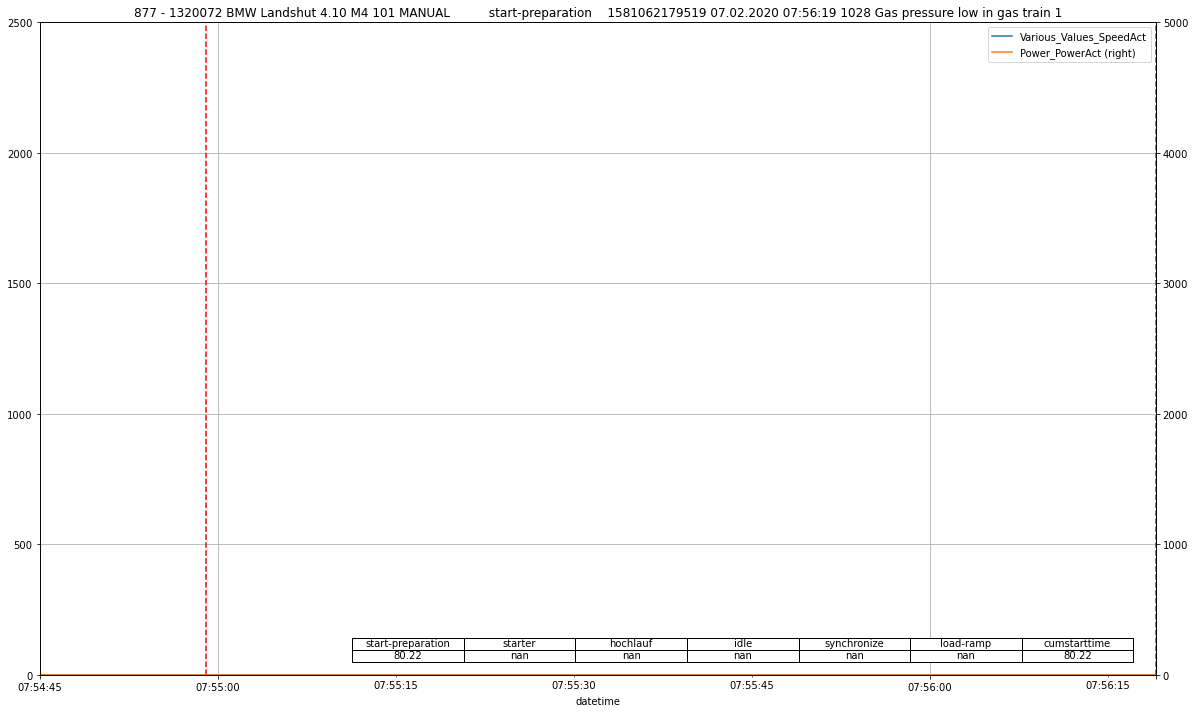


Startversuch: 878, Success: False
102 MANUAL          hochlauf             1581063101142 07.02.2020 08:11:41 3345 Ignition safety loop 


Load Data: 50000 datarows [00:00, 123954.82 datarows/s]                         


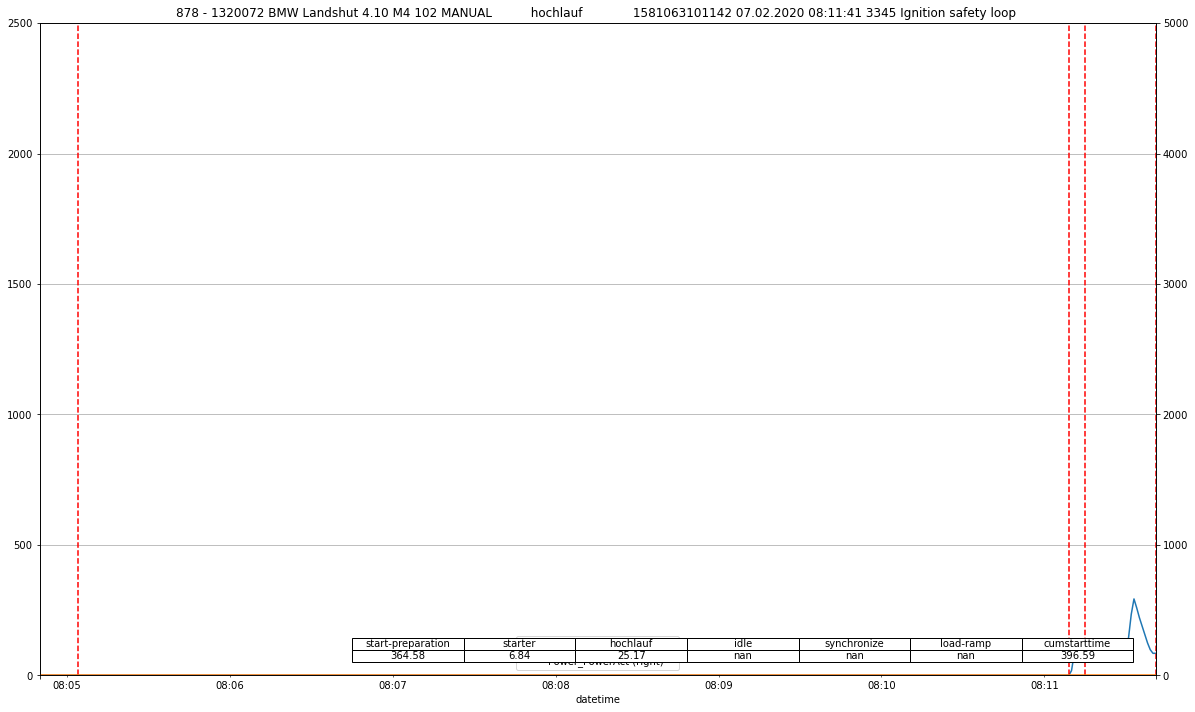


Startversuch: 892, Success: False
103 AUTO            synchronize          1582219256327 20.02.2020 17:20:56 1014 Abgasgegendruck Maximum

Startversuch: 906, Success: False
104 AUTO            load-ramp            1582843005308 27.02.2020 22:36:45 1138 Engine room ventilation failure
105 AUTO            load-ramp            1582843005509 27.02.2020 22:36:45 1056 Fail safe loop tripped
106 AUTO            load-ramp            1582843005808 27.02.2020 22:36:45 3096 Gas proportioning valve fuel gas pre-pressure out of limits

Startversuch: 986, Success: False
107 MANUAL          idle                 1590581445403 27.05.2020 12:10:45 1138 Engine room ventilation failure
108 MANUAL          idle                 1590581445502 27.05.2020 12:10:45 1056 Fail safe loop tripped

Startversuch: 987, Success: False
109 MANUAL          idle                 1590582059266 27.05.2020 12:20:59 1032 Heating water flow low
110 MANUAL          idle                 1590582059466 27.05.2020 12:20:59 1056 Fai

In [62]:
nalarms = []
ct = 0
ct2 = 0
mini = 100
maxi = 102
for i,c in rdf.iterrows():
    if len(c['alarms']) > 0 and not c['success']:
        ct += 1
        print(f"\nStartversuch: {i}, Success: {c['success']}")
        for a in c['alarms']:
            nalarms.append(a['msg'])
            _txt = f"{ct2} {c['mode']:15} {a['state']:20} {a['msg']['timestamp']} {pd.to_datetime(int(a['msg']['timestamp'])*1e6).strftime('%d.%m.%Y %H:%M:%S')} {a['msg']['name']} {a['msg']['message']}"
            print(_txt)
            if ct2 >= mini and ct2 <= maxi:
                fsm.plot_cycle(c, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {_txt}")
                plt.show()
            ct2 += 1

print(f"""
***********************************
** {ct:3} nicht erfolgreiche Starts **
***********************************
""")

In [ ]:
al = pd.DataFrame(fsm._pareto(nalarms))
fig = plt.figure();
color = 'purple'

if not al.empty:
    al['msg'] = al['msg'] + ' (' + al['name'] + ')'
    al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title='Alarms in not successful Starts');
    plt.plot();

In [ ]:
phases = [['start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation'],'start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation']
fig = plt.figure();
color = 'red'

for phase in phases:
    al = fsm.alarms_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [ ]:
phases = [['start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation'],'start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation']
fig = plt.figure();
color = 'orange'

for phase in phases:
    al = fsm.warnings_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [ ]:
mfn = './data/' + str(e._sn) + '_messages.txt'
fsm.save_messages('./data/' + str(e._sn) + '_messages.txt')
print(mfn)

In [ ]:
any(fsm._messages['name'] == '9047')

In [ ]:
#fsm.store()